# Stretch or squeeze the image

In [62]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from functools import partial
from cplAE_MET.models.torch_helpers import astensor, tonumpy
from cplAE_MET.utils.dataset import  load_M_inh_dataset
from cplAE_MET.models.augmentations import get_padded_im, get_soma_aligned_im
from cplAE_MET.models.pytorch_models import Encoder_M

In [93]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
astensor_ = partial(astensor, device=device)

D = load_M_inh_dataset("/Users/fahimehb/Documents/git-workspace/cplAE_MET/data/proc/M_im_data_3Nov2021.mat")
D['XM'] = np.expand_dims(D['XM'], axis=1)
D['X_sd'] = np.expand_dims(D['X_sd'], axis=1)

# soma depth is range (0,1) <-- check this
pad = 60
norm2pixel_factor = 100
padded_soma_coord = np.squeeze(D['X_sd'] * norm2pixel_factor + pad)
D['XM'] = get_padded_im(im=D['XM'], pad=pad)
D['XM'] = get_soma_aligned_im(im=D['XM'], soma_H=padded_soma_coord)
image = astensor_(D['XM'])

In [65]:
def aug_scale_im(im, scaling_by):
    '''
    Scaling the image by interpolation. The original images are padded beforehand to make sure they dont go out
    of the frame during the scaling. We padded them with H/2 along H
    Args:
        im: original images with the size of (N, 1, H, W, C)
        scaling_by: scaling factor for interpolation

    '''
    # scaling the cells
    min_rand = 1. - scaling_by
    max_rand = 1. + scaling_by
    depth_scaling_factor = (torch.rand(1) * (
                max_rand - min_rand) + min_rand).item()  # generate random numbers between min and max
    print(depth_scaling_factor)
    out = F.interpolate(im.float(), scale_factor=(depth_scaling_factor, 1, 1))  # scale the image
    return out

In [66]:
scaled_image = aug_scale_im(image, 0.5)

0.9951826930046082


/Users/fahimehb/miniconda3/envs/cpl37/lib/python3.7/site-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


In [68]:
Encoder_M.aug_scale_im(None, image, 0.5).shape

/Users/fahimehb/miniconda3/envs/cpl37/lib/python3.7/site-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


torch.Size([741, 1, 120, 4, 2])

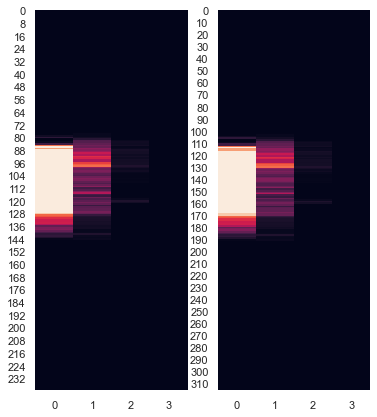

In [52]:
f, ax = plt.subplots(1, 2, figsize=(6,7))
sns.heatmap(np.squeeze(tonumpy(image))[0,:,:,0], cbar=False, ax=ax[0], vmin=0, vmax=1)
sns.heatmap(np.squeeze(tonumpy(scaled_image))[0,:,:,0], cbar=False, ax=ax[1], vmin=0, vmax=1)
plt.show()

Here we pad or crop the interpolated image

In [53]:
def pad_or_crop_im(scaled_im, im):
    '''
    Takes the scaled image and the original image and either crop or pad the scaled image to get the original size.
    Args:
        scaled_im: scaled image with the size of (N, 1, h, W, C), h is the scaled image height
        im: original image with the size of (N, 1, H, W, C)

    Returns:
        padded_or_copped_im: padded or cropped images with the size of (M, 1, H, W, C)

    '''
    out_depth = scaled_im.shape[2]
    in_depth = im.shape[2]

    # cropping or padding the image to get to the original size
    depth_diff = out_depth - in_depth
    patch = int(depth_diff / 2)
    patch_correction = (depth_diff) - patch * 2

    if depth_diff < 0:
        pad = (0, 0, 0, 0, -(patch + patch_correction), -patch)
        paded_or_croped_im = F.pad(scaled_im, pad, "constant", 0)

    elif depth_diff == 1:
        paded_or_croped_im = scaled_im[:, :, 1:, :, :]

    elif depth_diff == 0:
        paded_or_croped_im = scaled_im

    else:
        paded_or_croped_im = scaled_im[:, :, (patch + patch_correction): -patch, :, :]

    return paded_or_croped_im

In [54]:
def aug_scale(im, scaling_by=0.1):
    '''
    Scaling the image and then getting back to the original size by cropping or padding
    Args:
        im: soma aligned images with the size of (N, 1, H, W, C)
        scaling_by: scaling factor, a float between 0 and 1

    Returns:
        scaled image
    '''

    
    scaled_im = aug_scale_im(im, scaling_by)
    scaled_im = pad_or_crop_im(scaled_im, im)
    return scaled_im

In [55]:
paded_or_croped_image = pad_or_crop_im(scaled_image, image)

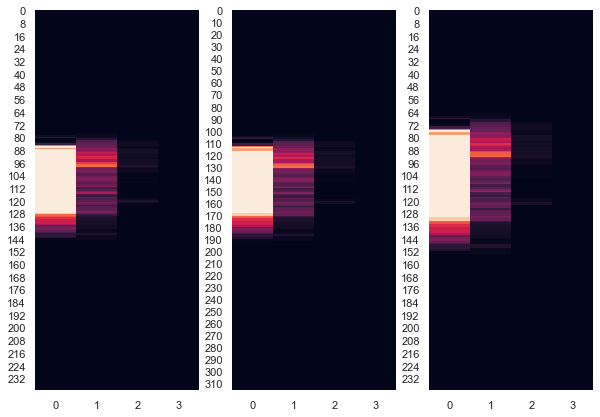

In [56]:
f, ax = plt.subplots(1, 3, figsize=(10,7))
sns.heatmap(np.squeeze(tonumpy(image))[0,:,:,0], cbar=False, ax=ax[0], vmin=0, vmax=1)
sns.heatmap(np.squeeze(tonumpy(scaled_image))[0,:,:,0], cbar=False, ax=ax[1], vmin=0, vmax=1)
sns.heatmap(np.squeeze(tonumpy(paded_or_croped_image))[0,:,:,0], cbar=False, ax=ax[2], vmin=0, vmax=1)

plt.show()

In [57]:
torch.Tensor(image).shape

torch.Size([741, 1, 240, 4, 2])

Now we will soma align the images again

In [60]:
image = np.zeros((1, 1, 240, 4, 2))
image[0, 0, 100:140, :, 0] =  1
scaled_image = aug_scale_im(torch.Tensor(image), 0.9)
paded_or_croped_image = pad_or_crop_im(scaled_image, image)


1.7569036483764648


<AxesSubplot:>

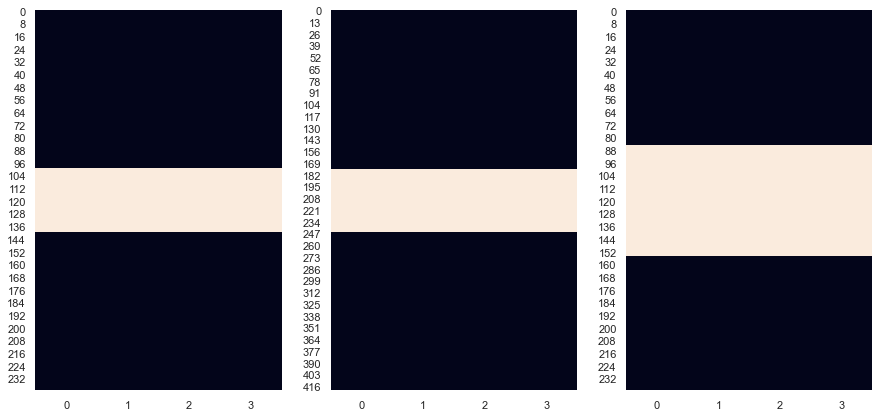

In [61]:
f, ax = plt.subplots(1, 3, figsize=(15,7))
sns.heatmap(np.squeeze((image))[:,:,0], cbar=False, ax=ax[0], vmin=0, vmax=1)
sns.heatmap(np.squeeze(tonumpy(scaled_image))[:,:,0], cbar=False, ax=ax[1], vmin=0, vmax=1)
sns.heatmap(np.squeeze(tonumpy(paded_or_croped_image))[:,:,0], cbar=False, ax=ax[2], vmin=0, vmax=1)